### Import

In [1]:
!pip install tensorflow

In [2]:
!pip install PyWavelets

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
!pip install matplotlib

In [5]:
import matplotlib.pyplot as plt

### Load Dataset

In [6]:
# Define your parameters here
batch_size = 32
img_height = 256
img_width = 256

# Use the correct local or mounted path
directory_train = 'C:/Users/admin/Documents/Project/Dataset/Training'

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

Found 5732 files belonging to 4 classes.


In [7]:
# Define your parameters here
batch_size = 32
img_height = 256
img_width = 256

# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Documents/Project/Dataset/Testing'

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    
    follow_links=False
)

Found 1311 files belonging to 4 classes.


In [8]:
import matplotlib.pyplot as plt

def show_batch(dataset, num_images=9):
    """
    Displays a batch of images from the dataset.

    Parameters:
    - dataset: The dataset from which to show images.
    - num_images: The number of images to display.

    """
    print(dataset.take(1))
    # Extract a batch of 'num_images' from the dataset
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            ax = plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(int(labels[i]))
            plt.axis("off")

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


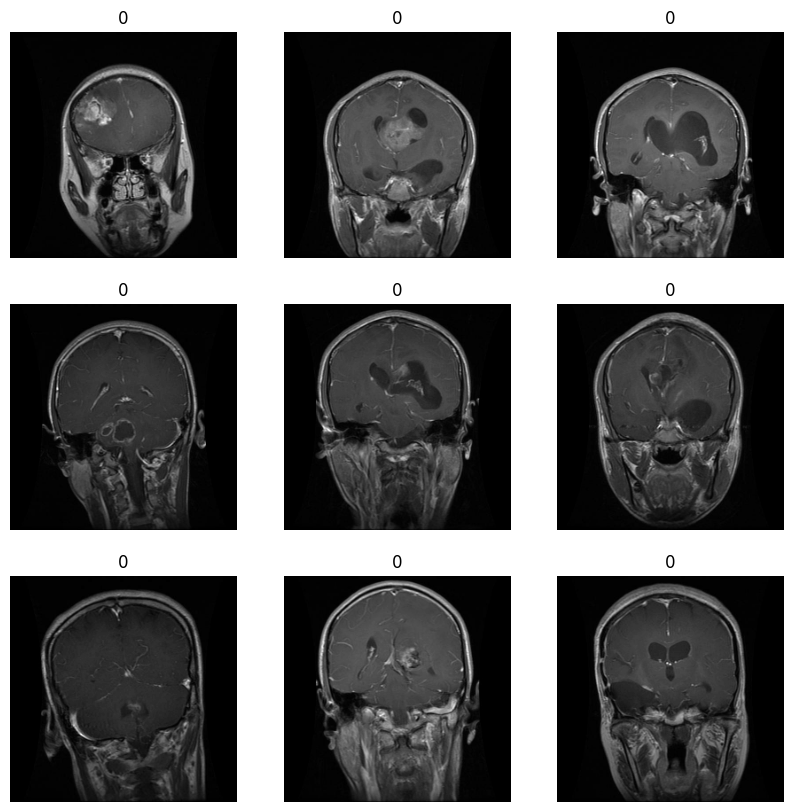

In [9]:
show_batch(ds_train)

### Data About Loaded Dataset

In [10]:
print(ds_test.class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
import os

def count_images_in_each_label(directory):
    # Initialize a dictionary to hold the count of images per label
    label_counts = {}
    
    # List all items in the directory
    for label in os.listdir(directory):
        # Construct the path to the label's directory
        label_dir = os.path.join(directory, label)
        
        # Check if the path is indeed a directory
        if os.path.isdir(label_dir):
            # Count the number of image files in the directory
            num_images = len([name for name in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, name))])
            label_counts[label] = num_images
            
    return label_counts

In [12]:
# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Documents/Project/Dataset/Training'

# Get the count of images in each label
label_counts = count_images_in_each_label(directory_test)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")

Label: glioma, Number of Images: 1321
Label: meningioma, Number of Images: 1359
Label: notumor, Number of Images: 1595
Label: pituitary, Number of Images: 1457


In [13]:
# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Documents/Project/Dataset/Testing'

# Get the count of images in each label
label_counts = count_images_in_each_label(directory_test)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")

Label: glioma, Number of Images: 300
Label: meningioma, Number of Images: 306
Label: notumor, Number of Images: 405
Label: pituitary, Number of Images: 300


### Median Filter

In [14]:
import tensorflow as tf
from typing import Optional, Union, List, Tuple, Iterable
import numpy as np


Number = Union[
    float,
    int,
    np.float16,
    np.float32,
    np.float64,
    np.int8,
    np.int16,
    np.int32,
    np.int64,
    np.uint8,
    np.uint16,
    np.uint32,
    np.uint64,
]

TensorLike = Union[
    List[Union[Number, list]],
    tuple,
    Number,
    np.ndarray,
    tf.Tensor,
    tf.SparseTensor,
    tf.Variable
]

def apply_median_filter(image, label):
    """
    Apply a median filter to an image.

    Args:
    - image: A tensor representing an image.
    - label: The corresponding label for the image.

    Returns:
    - filtered_image: The image after applying the median filter.
    - label: The unchanged label.
    """
    # Apply the median filter. The `filter_shape` parameter determines the size of the
    # window over which the median is computed. A larger value will lead to more smoothing.
    # Here, we use a 3x3 window as an example.
    filtered_image = median_filter2d(image, filter_shape=(3, 3))

    return filtered_image, label

# Assuming your dataset is named `ds_train`
# Apply the median filter to each image in the dataset
# ds_train_filtered = ds_train.map(apply_median_filter)

def get_ndims(image):
    return image.get_shape().ndims or tf.rank(image)


def to_4D_image(image):
    """Convert 2/3/4D image to 4D image.

    Args:
      image: 2/3/4D `Tensor`.

    Returns:
      4D `Tensor` with the same type.
    """
    with tf.control_dependencies(
        [
            tf.debugging.assert_rank_in(
                image, [2, 3, 4], message="`image` must be 2/3/4D tensor"
            )
        ]
    ):
        ndims = image.get_shape().ndims
        if ndims is None:
            return _dynamic_to_4D_image(image)
        elif ndims == 2:
            return image[None, :, :, None]
        elif ndims == 3:
            return image[None, :, :, :]
        else:
            return image

def _dynamic_to_4D_image(image):
    shape = tf.shape(image)
    original_rank = tf.rank(image)
    # 4D image => [N, H, W, C] or [N, C, H, W]
    # 3D image => [1, H, W, C] or [1, C, H, W]
    # 2D image => [1, H, W, 1]
    left_pad = tf.cast(tf.less_equal(original_rank, 3), dtype=tf.int32)
    right_pad = tf.cast(tf.equal(original_rank, 2), dtype=tf.int32)
    new_shape = tf.concat(
        [
            tf.ones(shape=left_pad, dtype=tf.int32),
            shape,
            tf.ones(shape=right_pad, dtype=tf.int32),
        ],
        axis=0,
    )
    return tf.reshape(image, new_shape)

def _dynamic_from_4D_image(image, original_rank):
    shape = tf.shape(image)
    # 4D image <= [N, H, W, C] or [N, C, H, W]
    # 3D image <= [1, H, W, C] or [1, C, H, W]
    # 2D image <= [1, H, W, 1]
    begin = tf.cast(tf.less_equal(original_rank, 3), dtype=tf.int32)
    end = 4 - tf.cast(tf.equal(original_rank, 2), dtype=tf.int32)
    new_shape = shape[begin:end]
    return tf.reshape(image, new_shape)

def from_4D_image(image, ndims):
    """Convert back to an image with `ndims` rank.

    Args:
      image: 4D `Tensor`.
      ndims: The original rank of the image.

    Returns:
      `ndims`-D `Tensor` with the same type.
    """
    with tf.control_dependencies(
        [tf.debugging.assert_rank(image, 4, message="`image` must be 4D tensor")]
    ):
        if isinstance(ndims, tf.Tensor):
            return _dynamic_from_4D_image(image, ndims)
        elif ndims == 2:
            return tf.squeeze(image, [0, 3])
        elif ndims == 3:
            return tf.squeeze(image, [0])
        else:
            return image

@tf.function
def median_filter2d(
    image: TensorLike,
    filter_shape: Union[int, Iterable[int]] = (3, 3),
    padding: str = "REFLECT",
    constant_values: TensorLike = 0,
    name: Optional[str] = None,
) -> tf.Tensor:
    """Perform median filtering on image(s).

    Args:
      image: Either a 2-D `Tensor` of shape `[height, width]`,
        a 3-D `Tensor` of shape `[height, width, channels]`,
        or a 4-D `Tensor` of shape `[batch_size, height, width, channels]`.
      filter_shape: An `integer` or `tuple`/`list` of 2 integers, specifying
        the height and width of the 2-D median filter. Can be a single integer
        to specify the same value for all spatial dimensions.
      padding: A `string`, one of "REFLECT", "CONSTANT", or "SYMMETRIC".
        The type of padding algorithm to use, which is compatible with
        `mode` argument in `tf.pad`. For more details, please refer to
        https://www.tensorflow.org/api_docs/python/tf/pad.
      constant_values: A `scalar`, the pad value to use in "CONSTANT"
        padding mode.
      name: A name for this operation (optional).
    Returns:
      2-D, 3-D or 4-D `Tensor` of the same dtype as input.
    Raises:
      ValueError: If `image` is not 2, 3 or 4-dimensional,
        if `padding` is other than "REFLECT", "CONSTANT" or "SYMMETRIC",
        or if `filter_shape` is invalid.
    """
    with tf.name_scope(name or "median_filter2d"):
        image = tf.convert_to_tensor(image, name="image")
        original_ndims = get_ndims(image)
        image = to_4D_image(image)

        filter_shape = normalize_tuple(filter_shape, 2, "filter_shape")

        image_shape = tf.shape(image)
        batch_size = image_shape[0]
        height = image_shape[1]
        width = image_shape[2]
        channels = image_shape[3]

        # Explicitly pad the image
        image = _pad(image, filter_shape, mode=padding, constant_values=constant_values)

        area = filter_shape[0] * filter_shape[1]

        floor = (area + 1) // 2
        ceil = area // 2 + 1

        patches = tf.image.extract_patches(
            image,
            sizes=[1, filter_shape[0], filter_shape[1], 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        patches = tf.reshape(patches, shape=[batch_size, height, width, area, channels])

        patches = tf.transpose(patches, [0, 1, 2, 4, 3])

        # Note the returned median is casted back to the original type
        # Take [5, 6, 7, 8] for example, the median is (6 + 7) / 2 = 3.5
        # It turns out to be int(6.5) = 6 if the original type is int
        top = tf.nn.top_k(patches, k=ceil).values
        if area % 2 == 1:
            median = top[:, :, :, :, floor - 1]
        else:
            median = (top[:, :, :, :, floor - 1] + top[:, :, :, :, ceil - 1]) / 2

        output = tf.cast(median, image.dtype)
        output = from_4D_image(output, original_ndims)
        return output

def normalize_tuple(value, n, name):
    """Transforms an integer or iterable of integers into an integer tuple.

    A copy of tensorflow.python.keras.util.

    Args:
      value: The value to validate and convert. Could an int, or any iterable
        of ints.
      n: The size of the tuple to be returned.
      name: The name of the argument being validated, e.g. "strides" or
        "kernel_size". This is only used to format error messages.

    Returns:
      A tuple of n integers.

    Raises:
      ValueError: If something else than an int/long or iterable thereof was
        passed.
    """
    if isinstance(value, int):
        return (value,) * n
    else:
        try:
            value_tuple = tuple(value)
        except TypeError:
            raise TypeError(
                "The `"
                + name
                + "` argument must be a tuple of "
                + str(n)
                + " integers. Received: "
                + str(value)
            )
        if len(value_tuple) != n:
            raise ValueError(
                "The `"
                + name
                + "` argument must be a tuple of "
                + str(n)
                + " integers. Received: "
                + str(value)
            )
        for single_value in value_tuple:
            try:
                int(single_value)
            except (ValueError, TypeError):
                raise ValueError(
                    "The `"
                    + name
                    + "` argument must be a tuple of "
                    + str(n)
                    + " integers. Received: "
                    + str(value)
                    + " "
                    "including element "
                    + str(single_value)
                    + " of type"
                    + " "
                    + str(type(single_value))
                )
        return value_tuple


def _pad(
    image: TensorLike,
    filter_shape: Union[List[int], Tuple[int]],
    mode: str = "CONSTANT",
    constant_values: TensorLike = 0,
) -> tf.Tensor:
    """Explicitly pad a 4-D image.

    Equivalent to the implicit padding method offered in `tf.nn.conv2d` and
    `tf.nn.depthwise_conv2d`, but supports non-zero, reflect and symmetric
    padding mode. For the even-sized filter, it pads one more value to the
    right or the bottom side.

    Args:
      image: A 4-D `Tensor` of shape `[batch_size, height, width, channels]`.
      filter_shape: A `tuple`/`list` of 2 integers, specifying the height
        and width of the 2-D filter.
      mode: A `string`, one of "REFLECT", "CONSTANT", or "SYMMETRIC".
        The type of padding algorithm to use, which is compatible with
        `mode` argument in `tf.pad`. For more details, please refer to
        https://www.tensorflow.org/api_docs/python/tf/pad.
      constant_values: A `scalar`, the pad value to use in "CONSTANT"
        padding mode.
    """
    if mode.upper() not in {"REFLECT", "CONSTANT", "SYMMETRIC"}:
        raise ValueError(
            'padding should be one of "REFLECT", "CONSTANT", or "SYMMETRIC".'
        )
    constant_values = tf.convert_to_tensor(constant_values, image.dtype)
    filter_height, filter_width = filter_shape
    pad_top = (filter_height - 1) // 2
    pad_bottom = filter_height - 1 - pad_top
    pad_left = (filter_width - 1) // 2
    pad_right = filter_width - 1 - pad_left
    paddings = [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]]
    return tf.pad(image, paddings, mode=mode, constant_values=constant_values)

In [15]:
ds_train_processed = ds_train.map(apply_median_filter)

In [16]:
ds_test_processed = ds_test.map(apply_median_filter)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


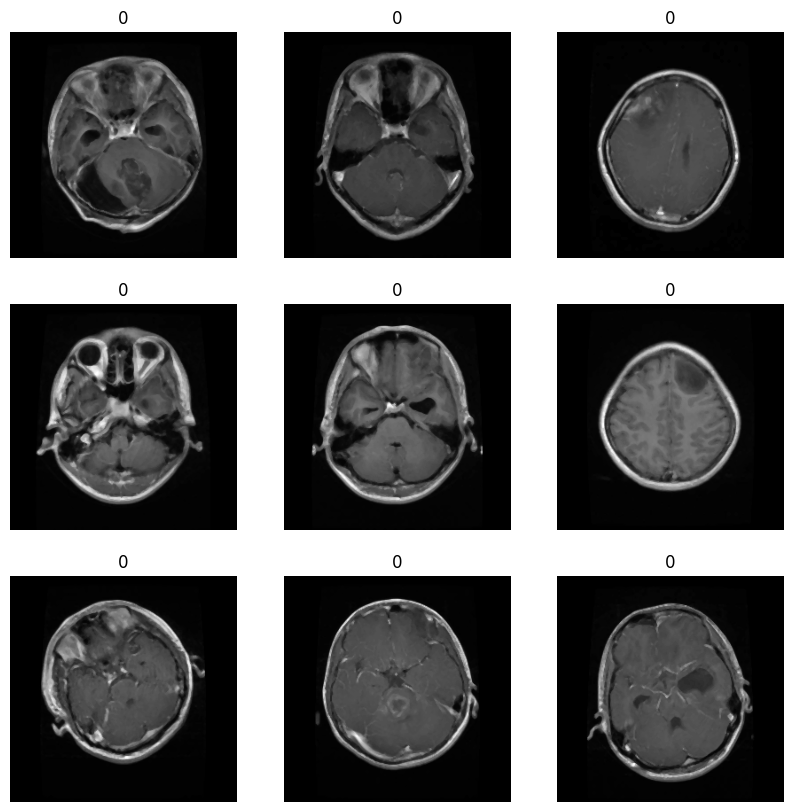

In [17]:
show_batch(ds_test_processed, num_images=9)

In [18]:
# i = 0
# j=0
# for images, labels in ds_test_processed.take(1):
for feature_batch, label_batch in ds_test_processed.take(1):
    # j = j+1
    print("batch", label_batch)
    print((feature_batch))
    # i = i + len(labels.numpy())
    # print("Class names:", ds_train.class_names)

batch tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...



In [19]:
len(ds_train_processed)

180

In [20]:
ds_test_processed

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
for images, labels in ds_test_processed.take(-1):
    print("Labels:", labels.numpy())
    print("Class names:", ds_train.class_names)

Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Image Segmentation

In [22]:
import tensorflow as tf

def segment_image(image, label):
    """
    Apply simple thresholding to segment the image.
    
    Ar
    gs:
    - image: The input image tensor.
    - label: The corresponding label tensor.
    
    Returns:
    - segmented_image: The segmented image tensor.
    - label: The unchanged label tensor.
    """
    # Convert the image to grayscale if it's not already
    image_gray = tf.image.rgb_to_grayscale(image) if image.shape[-1] == 3 else image
    
    # Normalize the image tensor to [0, 1]
    image_normalized = image_gray / 255.0
    
    # Define the threshold value
    threshold = 0.5  # This is a normalized threshold since the image is normalized
    
    # Apply thresholding
    segmented_image = tf.where(image_normalized < threshold, 0.0, 1.0)
    
    # The output segmented_image will have values 0 for background and 1 for foreground
    
    return segmented_image, label

In [23]:

# Assume ds is your TensorFlow dataset that has images and labels
ds_test_segmented = ds_test.map(segment_image)
ds_train_segmented = ds_train.map(segment_image)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


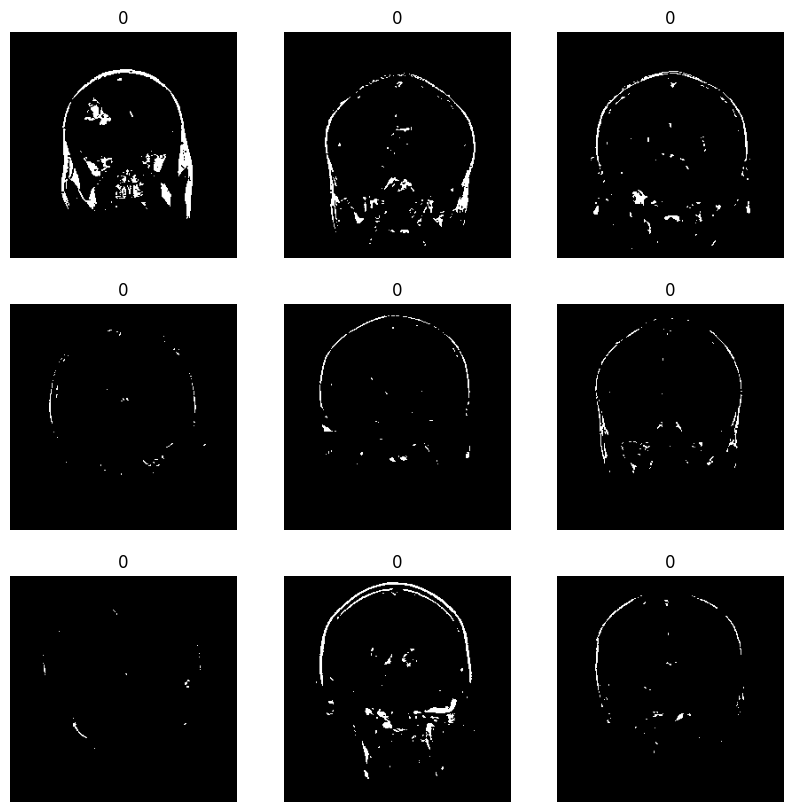

In [24]:
show_batch(ds_train_segmented, num_images=9)

# DWT

In [25]:
import pywt
import numpy as np
import tensorflow as tf

In [202]:
def apply_dwt_single(image):
    # Ensure image is 2D by removing the last dimension if it's 1
    if image.shape[-1] == 1:
        image = tf.squeeze(image, axis=-1)

    # print(type(image))
    # print(image.shape)
    # Convert the tensor to a numpy array for pywt
    # image_np = image.numpy()

    # coeffs = pywt.dwt2(image_np, 'haar')
    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs
    return LL

def apply_dwt_thrice(image):
    for i in range(3):
        image = apply_dwt_single(image)
    # After processing, add back the channel dimension
    image = np.expand_dims(image, axis=-1)
    return image

# Image will be tensor given by a tf.dataset
def dwt_applier(image, label):
    # print(image)
    # print(label)
    # Ensure operations are done outside TensorFlow's graph to use numpy and pywt
    image_dwt = tf.py_function(func=apply_dwt_thrice, inp=[image], Tout=tf.float64)

    # Ensure the output tensor has the right shape and type
    # image_dwt.set_shape((None, None, 1))  # We know the final channel dimension, but not spatial dimensions
    return image_dwt, label



In [27]:
ds_train_dwt = ds_train_segmented.map(dwt_applier)
ds_test_dwt = ds_test_segmented.map(dwt_applier)

Tensor("args_0:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("args_1:0", shape=(None,), dtype=int32)
Tensor("args_0:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("args_1:0", shape=(None,), dtype=int32)


In [28]:
print(len(ds_train))

180


In [29]:
print(len(ds_train_processed))

180


In [30]:
print(len(ds_train_segmented))

180


In [31]:
print(len(ds_train_dwt))

180


<_TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


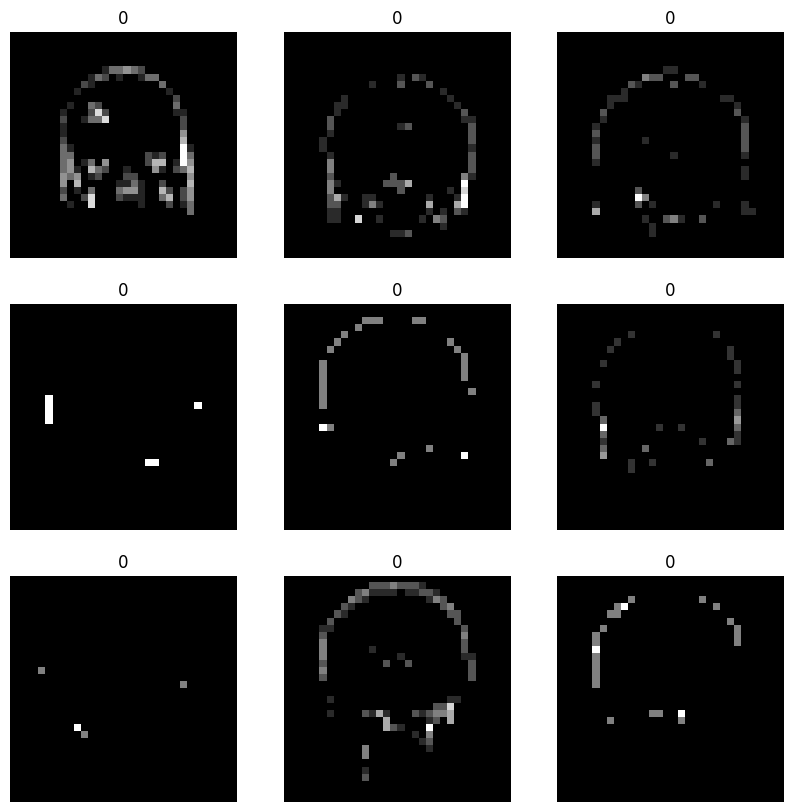

In [32]:
show_batch(ds_train_dwt, num_images=9)

In [33]:
ds_train_dwt.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
type(ds_train_dwt)

tensorflow.python.data.ops.map_op._MapDataset

In [35]:
# i = 0
# j=0
# for images, labels in ds_test_processed.take(1):
for feature_batch, label_batch in ds_train_dwt.take(1):
    print("batch", label_batch)
    print((feature_batch[31]))
    print(type(feature_batch[0]))

batch tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(32, 32, 1), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


### PCA

In [36]:
# ds_train_flat = ds_train_dwt.map(lambda features, label: (tf.reshape(features, [-1]), label))

In [37]:
# def dataset_to_numpy(ds):
#     features_list, labels_list = [], []
#     for features, label in ds:
#         features_list.append(features.numpy())
#         labels_list.append(label.numpy())
#     # Stack the list of features and convert labels list to a numpy array
#     features_np = np.vstack(features_list)
#     labels_np = np.array(labels_list)
#     return features_np, labels_np

In [38]:
# from sklearn.decomposition import PCA

# # Assuming ds_train_flat is your flattened dataset
# features, labels = dataset_to_numpy(ds_train_flat)

# Initialize PCA to reduce the features to 13 components
# pca = PCA(n_components=13)

# # Fit and transform the features
# features_pca = pca.fit_transform(features)

In [39]:
# ds_train_pca = tf.data.Dataset.from_tensor_slices((features_pca, labels))

# # Apply batching as needed
# batch_size = 32
# ds_train_pca = ds_train_pca.batch(batch_size)
# # 

In [40]:
# import tensorflow as tf
# import numpy as np

# def dataset_to_numpy(ds, expected_size=None):
#     features_list, labels_list = [], []
#     for features, label in ds.unbatch():  # Unbatch to process images individually
#         if expected_size:
#             # Flatten and resize if there's an expected size, otherwise just flatten
#             flat_feature = tf.reshape(features, [-1])[:expected_size]
#         else:
#             flat_feature = tf.reshape(features, [-1])
#         features_list.append(flat_feature.numpy())
#         labels_list.append(label.numpy())

#     # Ensure all features have the expected size
#     if expected_size:
#         features_np = np.array([f[:expected_size] for f in features_list])
#     else:
#         features_np = np.vstack(features_list)

#     labels_np = np.array(labels_list)
#     return features_np, labels_np

# # Determine the flattened size of your images (for 256x256x1 images, this would be 65536)
# flattened_size = 256 * 256



In [41]:
# Convert dataset to numpy, ensuring all feature vectors are of the same size
# features_train, labels_train = dataset_to_numpy(ds_train_dwt, expected_size=flattened_size)

In [42]:
# features_test, labels_test = dataset_to_numpy(ds_test_dwt, expected_size=flattened_size)

In [43]:
# features_test

In [44]:
# from sklearn.decomposition import PCA

# # Initialize PCA to reduce the features to 13 components
# pca = PCA(n_components=13)

In [45]:
# # Fit and transform the features
# features_pca_train = pca.fit_transform(features_train)
# features_pca_test = pca.fit_transform(features_test)

In [46]:
# ds_train_pca = tf.data.Dataset.from_tensor_slices((features_pca_train, labels_train))
# ds_test_pca = tf.data.Dataset.from_tensor_slices((features_pca_test, labels_test))

In [47]:
# # # Apply batching as needed
# batch_size = 32
# ds_train_pca = ds_train_pca.batch(batch_size)
# ds_test_pca = ds_test_pca.batch(batch_size)

# Dataset to Numpy

In [48]:
import numpy as np

def dataset_to_numpy(ds):
    features, labels = [], []
    for feature_batch, label_batch in ds:
        features.extend(feature_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = dataset_to_numpy(ds_train_dwt)
X_test, y_test = dataset_to_numpy(ds_test_dwt)

In [49]:
type(X_train[0])

numpy.ndarray

# ANN

In [50]:
img_height = None
img_width = 32

In [51]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

def create_mlp_model(input_shape, hidden_layers, output_units, learning_rate=0.3, momentum=0.2):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(output_units, activation='softmax'))  # Output layer
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [52]:
tf.random.set_seed(0)  # Set seed

img_height = 32
img_width = 32

# Assuming your input data is of shape (img_height, img_width, channels)
# Adjust this according to your actual data shape
input_shape = (img_height, img_width, 1)  
hidden_layers = [64, 64]  
output_units = len(ds_train.class_names) 


In [53]:
model = create_mlp_model(input_shape, hidden_layers, output_units, learning_rate=0.3, momentum=0.2)

c:\Users\admin\Documents\Project\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1)

In [55]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100, callbacks=[early_stopping], verbose=1)

Epoch 1/100


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4123 - loss: 1.9412 - val_accuracy: 0.4882 - val_loss: 1.1138
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5596 - loss: 1.1201 - val_accuracy: 0.5889 - val_loss: 0.8350
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6687 - loss: 0.7556 - val_accuracy: 0.7056 - val_loss: 0.7255
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7394 - loss: 0.6791 - val_accuracy: 0.6255 - val_loss: 0.7949
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7450 - loss: 0.6394 - val_accuracy: 0.7513 - val_loss: 0.6465
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7956 - loss: 0.5116 - val_accuracy: 0.7551 - val_loss: 0.6076
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8162 - loss: 0.4457 - val_accuracy: 0.7986 - val_loss: 0.5232
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8327 - loss: 0.3832 - val_accuracy: 0.7887 - val_loss: 0.6

In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

41/41 - 0s - 2ms/step - accuracy: 0.8513 - loss: 0.7831
Test accuracy: 0.8512585759162903, Test loss: 0.7831369042396545


In [57]:
y_train_ann_probs = model.predict(X_train)
y_test_ann_probs = model.predict(X_test)
y_train_ann_probs[0]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([1.6093018e-02, 9.8390698e-01, 5.1534935e-12, 9.0506597e-10],
      dtype=float32)

In [58]:
y_test_ann_probs[0]

array([9.9969387e-01, 3.0237666e-04, 5.3853925e-11, 3.8249700e-06],
      dtype=float32)

In [59]:
model.predict(X_test[0].reshape([1,32,32,1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[9.9969387e-01, 3.0237666e-04, 5.3854129e-11, 3.8249736e-06]],
      dtype=float32)

In [60]:
model.save('ann.keras')

In [61]:
load_ann = tf.keras.models.load_model('ann.keras')
load_ann.predict(X_test[0].reshape([1,32,32,1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


array([[9.9969387e-01, 3.0237666e-04, 5.3854129e-11, 3.8249736e-06]],
      dtype=float32)

KNN

In [62]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [63]:
# Normalize the data to [0, 1]
X_train_flat = X_train_flat.astype('float32') / 255.
X_test_flat = X_test_flat.astype('float32') / 255.


In [65]:
!pip install scikit-learn

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.4 kB 217.9 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.4 kB 217.9 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.4 kB 217.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 122.9 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 169.0 kB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 653.6 kB/s eta 0:00:17
   -------------------------

In [66]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Example: using 5 neighbors

# Train the KNN model
knn.fit(X_train_flat, y_train)

KNeighborsClassifier()

In [67]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = knn.predict(X_test_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Additional metrics
print(classification_report(y_test, y_pred))

knn_prob_train = knn.predict_proba(X_train_flat)
knn_prob_test = knn.predict_proba(X_test_flat)

knn_prob_test

Accuracy: 0.8306636155606407
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       300
           1       0.87      0.52      0.65       306
           2       0.84      0.94      0.89       405
           3       0.90      0.92      0.91       300

    accuracy                           0.83      1311
   macro avg       0.84      0.82      0.82      1311
weighted avg       0.84      0.83      0.82      1311



array([[1. , 0. , 0. , 0. ],
       [0.8, 0. , 0.2, 0. ],
       [0.4, 0. , 0.6, 0. ],
       ...,
       [0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. ]])

In [68]:
print(X_test_flat[0].reshape([1,1024]).shape)
knn.predict_proba(X_test_flat[1].reshape([1,1024]))

(1, 1024)


array([[0.8, 0. , 0.2, 0. ]])

SVM

In [69]:
# Assuming X_train and X_test are your datasets with images of shape (img_height, img_width, channels)
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0


In [70]:
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)  # Default settings; adjust as necessary

# Train the SVM model
svm.fit(X_train_flat, y_train)


SVC(probability=True)

In [71]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = svm.predict(X_test_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Additional metrics
print(classification_report(y_test, y_pred, target_names=ds_train.class_names))


Accuracy: 0.8596491228070176
              precision    recall  f1-score   support

      glioma       0.74      0.82      0.78       300
  meningioma       0.81      0.78      0.79       306
     notumor       0.98      0.90      0.94       405
   pituitary       0.89      0.93      0.91       300

    accuracy                           0.86      1311
   macro avg       0.86      0.86      0.85      1311
weighted avg       0.86      0.86      0.86      1311



In [207]:
svm_prob_train = svm.predict_proba(X_train_flat)
svm_prob_test = svm.predict_proba(X_test_flat)

svm_prob_test

array([[3.69919307e-01, 3.49720165e-01, 1.79854808e-01, 1.00505720e-01],
       [8.76301310e-01, 4.39240721e-02, 5.52160520e-02, 2.45585661e-02],
       [8.97762357e-01, 3.82849592e-02, 3.95183857e-02, 2.44342985e-02],
       ...,
       [1.58002527e-02, 1.47474785e-02, 1.75572976e-02, 9.51894971e-01],
       [7.76934462e-03, 3.47900638e-02, 7.79419319e-03, 9.49646398e-01],
       [4.40373005e-06, 1.29952485e-03, 2.22760861e-05, 9.98673795e-01]])

In [208]:
svm.predict_proba(X_test_flat[1].reshape([1,1024]))

array([[0.87630131, 0.04392407, 0.05521605, 0.02455857]])

In [74]:
print(type(y_test_ann_probs[0]))
print(type(svm_prob_test[0]))
print(type(knn_prob_test[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [75]:
import pickle
knnPickle = open('knnpickle_file', 'wb') 
      
# source, destination 
pickle.dump(knn, knnPickle)  

# close the file
knnPickle.close()
                
      
# load the model from disk
loaded_model = pickle.load(open('knnpickle_file', 'rb'))
result = loaded_model.predict(X_test_flat) 

In [76]:
import pickle
svmPickle = open('svmpickle_file', 'wb') 
      
# source, destination 
pickle.dump(svm, svmPickle)  

# close the file
svmPickle.close()
                
      
# load the model from disk
loaded_model = pickle.load(open('svmpickle_file', 'rb'))
result = loaded_model.predict(X_test_flat) 

# DST


In [77]:
!pip install pyds


  Using cached pyds-0.2.0-py3-none-any.whl


In [78]:
import pyds

In [239]:
"""
A framework for performing computations in the Dempster-Shafer theory.
"""

from __future__ import print_function
from itertools import chain, combinations
from functools import partial, reduce
from operator import mul
from math import log, fsum, sqrt
from random import random, shuffle, uniform
import sys

try:
    import numpy
    try:
        from scipy.stats import chi2
        from scipy.optimize import fmin_cobyla
    except:
        print('SciPy not found: some features will not work.', file=sys.stderr)
except:
    print('NumPy not found: some features will not work.', file=sys.stderr)


class MassFunction(dict):
    """
    A Dempster-Shafer mass function (basic probability assignment) based on a dictionary.
    
    Both normalized and unnormalized mass functions are supported.
    The underlying frame of discernment is assumed to be discrete.
    
    Hypotheses and their associated mass values can be added/changed/removed using the standard dictionary methods.
    Each hypothesis can be an arbitrary sequence which is automatically converted to a 'frozenset', meaning its elements must be hashable.
    """
    
    def __init__(self, source=None):
        """
        Creates a new mass function.
        
        If 'source' is not None, it is used to initialize the mass function.
        It can either be a dictionary mapping hypotheses to non-negative mass values
        or an iterable containing tuples consisting of a hypothesis and a corresponding mass value.
        """
        if source != None:
            if isinstance(source, dict):
                source = source.items()
            for (h, v) in source:
                self[h] += v
    
    @staticmethod
    def _convert(hypothesis):
        """Convert hypothesis to a 'frozenset' in order to make it hashable."""
        if isinstance(hypothesis, frozenset):
            return hypothesis
        else:
            return frozenset(hypothesis)
    
    @staticmethod
    def gbt(likelihoods, normalization=True, sample_count=None):
        """
        Constructs a mass function using the generalized Bayesian theorem.
        For more information, see Smets. 1993. Belief functions: 
        The disjunctive rule of combination and the generalized Bayesian theorem. International Journal of Approximate Reasoning. 
        
        'likelihoods' specifies the conditional plausibilities for a set of singleton hypotheses.
        It can either be a dictionary mapping singleton hypotheses to plausibilities or an iterable
        containing tuples consisting of a singleton hypothesis and a corresponding plausibility value.
        
        'normalization' determines whether the resulting mass function is normalized, i.e., whether m({}) == 0.
        
        If 'sample_count' is not None, the true mass function is approximated using the specified number of samples.
        """
        m = MassFunction()
        if isinstance(likelihoods, dict):
            likelihoods = list(likelihoods.items())
        # filter trivial likelihoods 0 and 1
        ones = [h for (h, l) in likelihoods if l >= 1.0]
        likelihoods = [(h, l) for (h, l) in likelihoods if 0.0 < l < 1.0]
        if sample_count == None:   # deterministic
            def traverse(m, likelihoods, ones, index, hyp, mass):
                if index == len(likelihoods):
                    m[hyp + ones] = mass
                else:
                    traverse(m, likelihoods, ones, index + 1, hyp + [likelihoods[index][0]], mass * likelihoods[index][1])
                    traverse(m, likelihoods, ones, index + 1, hyp, mass * (1.0 - likelihoods[index][1]))
            traverse(m, likelihoods, ones, 0, [], 1.0)
            if normalization:
                m.normalize()
        else:   # Monte-Carlo
            if normalization:
                empty_mass = reduce(mul, [1.0 - l[1] for l in likelihoods], 1.0)
            for _ in range(sample_count):
                rv = [random() for _ in range(len(likelihoods))]
                subtree_mass = 1.0
                hyp = set(ones)
                for k in range(len(likelihoods)):
                    l = likelihoods[k][1]
                    p_t = l * subtree_mass
                    p_f = (1.0 - l) * subtree_mass
                    if normalization and not hyp: # avoid empty hypotheses in the normalized case
                        p_f -= empty_mass
                    if p_t > rv[k] * (p_t + p_f):
                        hyp.add(likelihoods[k][0])
                    else:
                        subtree_mass *= 1 - l # only relevant for the normalized empty case
                m[hyp] += 1.0 / sample_count
        return m
    
    @staticmethod
    def from_bel(bel):
        """
        Creates a mass function from a corresponding belief function.
        
        'bel' is a dictionary mapping hypotheses to belief values (like the dictionary returned by 'bel(None)').
        """
        m = MassFunction()
        for h1 in bel.keys():
            v = fsum([bel[h2] * (-1)**(len(h1 - h2)) for h2 in powerset(h1)])
            if v > 0:
                m[h1] = v
        mass_sum = fsum(m.values())
        if mass_sum < 1.0:
            m[frozenset()] = 1.0 - mass_sum
        return m
    
    @staticmethod
    def from_pl(pl):
        """
        Creates a mass function from a corresponding plausibility function.
        
        'pl' is a dictionary mapping hypotheses to plausibility values (like the dictionary returned by 'pl(None)').
        """
        frame = max(pl.keys(), key=len)
        bel_theta = pl[frame]
        bel = {frozenset(frame - h):bel_theta - v for (h, v) in pl.items()} # follows from bel(-A) = bel(frame) - pl(A)
        return MassFunction.from_bel(bel)
    
    @staticmethod
    def from_q(q):
        """
        Creates a mass function from a corresponding commonality function.
        
        'q' is a dictionary mapping hypotheses to commonality values (like the dictionary returned by 'q(None)').
        """
        m = MassFunction()
        frame = max(q.keys(), key=len)
        for h1 in q.keys():
            v = fsum([q[h1 | h2] * (-1)**(len(h2 - h1)) for h2 in powerset(frame - h1)])
            if v > 0:
                m[h1] = v
        mass_sum = fsum(m.values())
        if mass_sum < 1.0:
            m[frozenset()] = 1.0 - mass_sum
        return m
    
    def __missing__(self, key):
        """Return 0 mass for hypotheses that are not contained."""
        return 0.0
    
    def __copy__(self):
        c = MassFunction()
        for k, v in self.items():
            c[k] = v
        return c
    
    def copy(self):
        """Creates a shallow copy of the mass function."""
        return self.__copy__()
    
    def __contains__(self, hypothesis):
        return dict.__contains__(self, MassFunction._convert(hypothesis))
    
    def __getitem__(self, hypothesis):
        return dict.__getitem__(self, MassFunction._convert(hypothesis))
    
    def __setitem__(self, hypothesis, value):
        """
        Adds or updates the mass value of a hypothesis.
        
        'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        In case of a negative mass value, a ValueError is raised.
        """
        if value < 0.0:
            raise ValueError("mass value is negative: %f" % value)
        dict.__setitem__(self, MassFunction._convert(hypothesis), value)
    
    def __delitem__(self, hypothesis):
        return dict.__delitem__(self, MassFunction._convert(hypothesis))
    
    def frame(self):
        """
        Returns the frame of discernment of the mass function as a 'frozenset'.
        
        The frame of discernment is the union of all contained hypotheses.
        In case the mass function does not contain any hypotheses, an empty set is returned.
        """
        if not self:
            return frozenset()
        else:
            return frozenset.union(*self.keys())
    
    def singletons(self):
        """
        Returns the set of all singleton hypotheses.
        
        Like 'frame()', except that each singleton is wrapped in a frozenset
        and can thus be directly passed to methods like 'bel()'.
        """
        return {frozenset((s,)) for s in self.frame()}
    
    def focal(self):
        """
        Returns the set of all focal hypotheses.
        
        A focal hypothesis has a mass value greater than 0.
        """
        return {h for (h, v) in self.items() if v > 0}
    
    def core(self, *mass_functions):
        """
        Returns the core of one or more mass functions as a 'frozenset'.
        
        The core of a single mass function is the union of all its focal hypotheses.
        In case a mass function does not contain any focal hypotheses, its core is an empty set.
        If multiple mass functions are given, their combined core (intersection of all single cores) is returned.
        """
        if mass_functions:
            return frozenset.intersection(self.core(), *[m.core() for m in mass_functions])
        else:
            focal = self.focal()
            if not focal:
                return frozenset()
            else:
                return frozenset.union(*focal)
    
    def all(self):
        """Returns an iterator over all subsets of the frame of discernment, including the empty set."""
        return powerset(self.frame())
    
    def bel(self, hypothesis=None):
        """
        Computes either the belief of 'hypothesis' or the entire belief function (hypothesis=None).
        
        If 'hypothesis' is None (default), a dictionary mapping hypotheses to their respective belief values is returned.
        Otherwise, the belief of 'hypothesis' is returned.
        In this case, 'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        """
        if hypothesis is None:
            return {h:self.bel(h) for h in powerset(self.core())}
        else:
            hypothesis = MassFunction._convert(hypothesis)
            if not hypothesis:
                return 0.0
            else:
                return fsum([v for (h, v) in self.items() if h and hypothesis.issuperset(h)])
    
    def pl(self, hypothesis=None):
        """
        Computes either the plausibility of 'hypothesis' or the entire plausibility function (hypothesis=None).
        
        If 'hypothesis' is None (default), a dictionary mapping hypotheses to their respective plausibility values is returned.
        Otherwise, the plausibility of 'hypothesis' is returned.
        In this case, 'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        """
        if hypothesis is None:
            return {h:self.pl(h) for h in powerset(self.core())}
        else:
            hypothesis = MassFunction._convert(hypothesis)
            if not hypothesis:
                return 0.0
            else:
                return fsum([v for (h, v) in self.items() if hypothesis & h])
    
    def q(self, hypothesis=None):
        """
        Computes either the commonality of 'hypothesis' or the entire commonality function (hypothesis=None).
        
        If 'hypothesis' is None (default), a dictionary mapping hypotheses to their respective commonality values is returned.
        Otherwise, the commonality of 'hypothesis' is returned.
        In this case, 'hypothesis' is automatically converted to a 'frozenset' meaning its elements must be hashable.
        """
        if hypothesis is None:
            return {h:self.q(h) for h in powerset(self.core())}
        else:
            if not hypothesis:
                return 1.0
            else:
                return fsum([v for (h, v) in self.items() if h.issuperset(hypothesis)])
    
    def __and__(self, mass_function):
        """Shorthand for 'combine_conjunctive(mass_function)'."""
        return self.combine_conjunctive(mass_function)
    
    def __or__(self, mass_function):
        """Shorthand for 'combine_disjunctive(mass_function)'."""
        return self.combine_disjunctive(mass_function)
    
    def __str__(self):
        hyp = sorted([(v, h) for (h, v) in self.items()], reverse=True)
        return "{" + "; ".join([str(set(h)) + ":" + str(v) for (v, h) in hyp]) + "}"
    
    def __mul__(self, scalar):
        if not isinstance(scalar, float):
            raise TypeError('Can only multiply by a float value.')
        m = MassFunction()
        for (h, v) in self.items():
            m[h] = v * scalar
        return m
    
    def __rmul__(self, scalar):
        return self.__mul__(scalar)
    
    def __add__(self, m):
        if not isinstance(m, MassFunction):
            raise TypeError('Can only add two mass functions.')
        result = self.copy()
        for (h, v) in m.items():
            result[h] += v
        return result
    
    def weight_function(self):
        """
        Computes the weight function corresponding to this mass function.
        """
        weights = dict()
        q = self.q()
        theta = self.frame()
        for h in powerset(theta):
            if len(h) < len(theta): # weight is undefined for theta
                sets = [h | c for c in powerset(theta - h)]
                q_even = reduce(mul, [q[h2] for h2 in sets if len(h2) % 2 == 0], 1.0)
                q_odd = reduce(mul, [q[h2] for h2 in sets if len(h2) % 2 == 1], 1.0)
                if len(h) % 2 == 0:
                    weights[h] = q_odd / q_even
                else:
                    weights[h] = q_even / q_odd
        return weights
    
    def combine_conjunctive(self, mass_function, normalization=True, sample_count=None, importance_sampling=False):
        """
        Conjunctively combines the mass function with another mass function and returns the combination as a new mass function.
        
        The other mass function is assumed to be defined over the same frame of discernment.
        If 'mass_function' is not of type MassFunction, it is assumed to be an iterable containing multiple mass functions that are iteratively combined.
        
        If the mass functions are flatly contracting or if one of the mass functions is empty, an empty mass function is returned.
        
        'normalization' determines whether the resulting mass function is normalized (default is True).
         
        If 'sample_count' is not None, the true combination is approximated using the specified number of samples.
        In this case, 'importance_sampling' determines the method of approximation (only if normalization=True, otherwise 'importance_sampling' is ignored).
        The default method (importance_sampling=False) independently generates samples from both mass functions and computes their intersections.
        If importance_sampling=True, importance sampling is used to avoid empty intersections, which leads to a lower approximation error but is also slower.
        This method should be used if there is significant evidential conflict between the mass functions.
        """
        return self._combine(mass_function, rule=lambda s1, s2: s1 & s2, normalization=normalization, sample_count=sample_count, importance_sampling=importance_sampling)
    
    def combine_disjunctive(self, mass_function, sample_count=None):
        """
        Disjunctively combines the mass function with another mass function and returns the combination as a new mass function.
        
        The other mass function is assumed to be defined over the same frame of discernment.
        If 'mass_function' is not of type MassFunction, it is assumed to be an iterable containing multiple mass functions that are iteratively combined.
        
        If 'sample_count' is not None, the true combination is approximated using the specified number of samples.
        """
        return self._combine(mass_function, rule=lambda s1, s2: s1 | s2, normalization=False, sample_count=sample_count, importance_sampling=False)
    
    def combine_cautious(self, mass_function):
        """
        Combines the mass function with another mass function using the cautious rule and returns the combination as a new mass function.
        
        For more details, see:
        T. Denoeux (2008), "Conjunctive and disjunctive combination of belief functions induced by nondistinct bodies of evidence",
        Artificial Intelligence 172, 234-264.
        """
        w1 = self.weight_function()
        w2 = mass_function.weight_function()
        w_min = {h:min(w1[h], w2[h]) for h in w1}
        theta = self.frame()
        m = MassFunction({theta:1.0})
        for h, w in w_min.items():
            m_simple = MassFunction({theta:w, h:1.0 - w})
            m = m.combine_conjunctive(m_simple, normalization=False)
        return m
    
    def _combine(self, mass_function, rule, normalization, sample_count, importance_sampling):
        """Helper method for combining two or more mass functions."""
        combined = self
        if isinstance(mass_function, MassFunction):
            mass_function = [mass_function] # wrap single mass function
        for m in mass_function:
            if not isinstance(m, MassFunction):
                raise TypeError("expected type MassFunction but got %s; make sure to use keyword arguments for anything other than mass functions" % type(m))
            if sample_count == None:
                combined = combined._combine_deterministic(m, rule)
            else:
                if importance_sampling and normalization:
                    combined = combined._combine_importance_sampling(m, sample_count)
                else:
                    combined = combined._combine_direct_sampling(m, rule, sample_count)
        if normalization:
            return combined.normalize()
        else:
            return combined
    
    def _combine_deterministic(self, mass_function, rule):
        """Helper method for deterministically combining two mass functions."""
        combined = MassFunction()
        for (h1, v1) in self.items():
            for (h2, v2) in mass_function.items():
                combined[rule(h1, h2)] += v1 * v2
        return combined
    
    def _combine_direct_sampling(self, mass_function, rule, sample_count):
        """Helper method for approximatively combining two mass functions using direct sampling."""
        combined = MassFunction()
        samples1 = self.sample(sample_count)
        samples2 = mass_function.sample(sample_count)
        for i in range(sample_count):
            combined[rule(samples1[i], samples2[i])] += 1.0 / sample_count
        return combined
    
    def _combine_importance_sampling(self, mass_function, sample_count):
        """Helper method for approximatively combining two mass functions using importance sampling."""
        combined = MassFunction()
        for (s1, n) in self.sample(sample_count, as_dict=True).items():
            weight = mass_function.pl(s1)
            for s2 in mass_function.condition(s1).sample(n):
                combined[s2] += weight
        return combined
    
    def combine_gbt(self, likelihoods, normalization=True, sample_count=None, importance_sampling=True):
        """
        Conjunctively combines the mass function with a mass function obtained from a sequence of
        likelihoods via the generalized Bayesian theorem and returns the combination as a new mass function.
        
        Equivalent to 'combine_conjunctive(MassFunction.gbt(likelihoods))'.
        By ignoring incompatible likelihoods, it is generally faster than the former
        method and yields a better Monte-Carlo approximation in case of normalization.
        
        'likelihoods' specifies the conditional plausibilities for a set of singleton hypotheses.
        It can either be a dictionary mapping singleton hypotheses to plausibilities or an iterable
        containing tuples consisting of a singleton hypothesis and a corresponding plausibility value.
        
        All arguments except for 'likelihoods' must be specified as keyword arguments.
        'normalization' determines whether the resulting mass function is normalized, i.e., whether m({}) == 0.
        If 'sample_count' is not None, the true mass function is approximated using the specified number of samples.
        See 'combine_conjunctive' for details on the effect of setting 'importance_sampling'.
        """
        core = self.core() # restrict to generally compatible likelihoods
        if isinstance(likelihoods, dict):
            likelihoods = list(likelihoods.items())
        likelihoods = [l for l in likelihoods if l[1] > 0 and l[0] in core]
        if sample_count == None: # deterministic
            return self.combine_conjunctive(MassFunction.gbt(likelihoods), normalization=normalization)
        else: # Monte-Carlo
            if not normalization: # only use importance sampling in case of normalization
                importance_sampling = False
            combined = MassFunction()
            for s, n in self.sample(sample_count, as_dict=True).items():
                if importance_sampling:
                    compatible_likelihoods = [l for l in likelihoods if l[0] in s]
                    weight = 1.0 - reduce(mul, [1.0 - l[1] for l in compatible_likelihoods], 1.0)
                else:
                    compatible_likelihoods = likelihoods
                if not compatible_likelihoods:
                    continue
                if normalization:
                    empty_mass = reduce(mul, [1.0 - l[1] for l in compatible_likelihoods], 1.0)
                for _ in range(n):
                    rv = [random() for _ in range(len(compatible_likelihoods))]
                    subtree_mass = 1.0
                    hyp = set()
                    for k in range(len(compatible_likelihoods)):
                        l = compatible_likelihoods[k][1]
                        norm = 1.0 if hyp or not normalization else 1.0 - empty_mass / subtree_mass
                        if l / norm > rv[k]:
                            hyp.add(compatible_likelihoods[k][0])
                        else:
                            subtree_mass *= 1.0 - l   # only relevant for negative case
                    if importance_sampling:
                        combined[hyp] += weight
                    else:
                        combined[hyp & s] += 1.0
            if normalization:
                return combined.normalize()
            else:
                return combined
    
    def condition(self, hypothesis, normalization=True):
        """
        Conditions the mass function with 'hypothesis'.
        
        'normalization' determines whether the resulting conjunctive combination is normalized (must be specified as a keyword argument).
        
        Shorthand for self.combine_conjunctive(MassFunction({hypothesis:1.0}), normalization).
        """
        m = MassFunction({MassFunction._convert(hypothesis):1.0})
        return self.combine_conjunctive(m, normalization=normalization)
    
    def conflict(self, mass_function, sample_count=None):
        """
        Calculates the weight of conflict between two or more mass functions.
        
        If 'mass_function' is not of type MassFunction, it is assumed to be an iterable containing multiple mass functions.
        
        The weight of conflict is computed as the (natural) logarithm of the normalization constant in Dempster's rule of combination.
        Returns infinity in case the mass functions are flatly contradicting.
        """
        # compute full conjunctive combination (could be more efficient)
        m = self.combine_conjunctive(mass_function, normalization=False, sample_count=sample_count)
        empty = m[frozenset()]
        m_sum = fsum(m.values())
        diff = m_sum - empty
        if diff == 0.0:
            return float('inf')
        else:
            return -log(diff)
    
    def normalize(self):
        """
        Normalizes the mass function in-place.
        
        Sets the mass value of the empty set to 0 and scales all other values such that their sum equals 1.
        For convenience, the method returns 'self'.
        """
        if frozenset() in self:
            del self[frozenset()]
        mass_sum = fsum(self.values())
        if mass_sum != 1.0:
            for (h, v) in self.items():
                self[h] = v / mass_sum
        return self
    
    def prune(self):
        """
        Removes all non-focal (0 mass) hypotheses in-place.
        
        For convenience, the method returns 'self'.
        """ 
        remove = [h for (h, v) in self.items() if v == 0.0]
        for h in remove:
            del self[h]
        return self
    
    def markov(self, transition_model, sample_count=None):
        """
        Computes the mass function induced by a prior belief (self) and a transition model.
        
        The transition model expresses a joint belief over the frame of this mass function and a new frame.
        The belief over the frame of this mass function is implicitly assumed to be vacuous.
        The transition model is a function returning the conditional belief over the new frame (as a mass function
        if sample_count=None) while taking a singleton hypothesis of the current frame as input.
        The disjunctive rule of combination is then used to construct the mass function over the new frame.
        
        If 'sample_count' is not None, the true mass function is approximated using the specified number of samples.
        In this case, 'transition_model' is expected to take a second argument stating how many samples from the corresponding conditional mass function should be returned.
        The return value in this case is expected to be an iterable over sampled hypotheses from the new frame.
         
        This method can be used to implement the prediction step for estimation in a hidden Markov process (hence the name).
        Under this interpretation, the transition model expresses the mass distribution over successor states given the current state.
        """
        updated = MassFunction()
        if sample_count == None: # deterministic
            for k, v in self.items():
                predicted = None
                for e in k:
                    if predicted == None:
                        predicted = transition_model(e)
                    else:
                        predicted |= transition_model(e)
                for kp, vp in predicted.items():
                    updated[kp] += v * vp
        else: # Monte-Carlo
            for s, n in self.sample(sample_count, as_dict=True).items():
                unions = [[] for _ in range(n)]
                for e in s:
                    ts = transition_model(e, n)
                    for i, t in enumerate(ts):
                        unions[i].extend(t)
                for u in unions:
                    updated[u] += 1.0 / sample_count
        return updated
    
    def map(self, function):
        """
        Maps each hypothesis to a new hypothesis using 'function' and returns the new mass function.
        
        'function' is a function taking a hypothesis as its only input and returning a new hypothesis
        (i.e., a sequence that can be converted to a 'frozenset').
        
        Here are some example use cases:
        
        1. Vacuous extension to a multi-dimensional frame of discernment (m is defined over
        the frame A while the new mass function is defined over the Cartesian product AxB):
            
            B = {'x', 'y', 'z'}
            m.map(lambda h: itertools.product(h, B))
        
        2. Projection to a lower dimensional frame (m is defined over AxBxC such that each hypothesis is
        a set of tuples where each tuple consists of 3 elements; the new mass function is defined over BxC):
        
            m.map(lambda h: (t[1:] for t in h))
        """
        m = MassFunction()
        for (h, v) in self.items():
            m[self._convert(function(h))] += v
        return m
    
    def pignistic(self):
        """Computes the pignistic transformation and returns it as a new mass function consisting only of singletons."""
        p = MassFunction()
        for (h, v) in self.items():
            if v > 0.0:
                size = float(len(h))
                for s in h:
                    p[(s,)] += v / size
        return p.normalize()
    
    def local_conflict(self):
        """
        Computes the local conflict measure.
        
        For more information, see Pal et al. 1993. Uncertainty measures for evidential reasoning II:
        A new measure of total uncertainty. International Journal of Approximate Reasoning.
        
        Only works for normalized mass functions.
        If the mass function is unnormalized, the method returns float('nan')
        
        In case the mass function is a probability function (containing only singleton hypotheses),
        it reduces to the classical entropy measure.
        """
        if self[frozenset()] > 0.0:
            return float('nan')
        c = 0.0
        for (h, v) in self.items():
            if v > 0.0:
                c += v * log(len(h) / v, 2)
        return c
    
    def hartley_measure(self):
        """
        Computes the Hartley-like measure in order to quantify the amount of imprecision.
        
        For more information, see:
        G. J. Klir (1999), "Uncertainty and information measures for imprecise probabilities: An overview",
        International Symposium on Imprecise Probabilities and Their Applications.
        """
        return fsum([v * log(len(h), 2) for h, v in self.items()])
    
    def norm(self, m, p=2):
        """
        Computes the p-norm between two mass functions (default is p=2).
        
        Both mass functions are treated as vectors of mass values.
        """
        d = fsum([(v - m[h])**p for (h, v) in self.items()])
        for (h, v) in m.items():
            if h not in self:
                d += v**p
        return d**(1.0 / p)
    
    def is_compatible(self, m):
        """
        Checks whether another mass function is compatible with this one.
        
        Compatibility means that the mass value of each hypothesis in 'm' is less than
        or equal to the corresponding plausibility given by this mass function.
        """
        return all([self.pl(h) >= v for (h, v) in m.items()])
    
    def sample(self, n, quantization=True, as_dict=False):
        """
        Returns n random samples from the mass distribution.
        
        Hypotheses are drawn with a probability proportional to their mass values (with replacement).
         
        If 'quantization' is True (default), the method performs a quantization of the mass values.
        This means the frequency of a hypothesis h in the sample set is at least int(self[h] * n / t) where t is the sum of all mass values.
        The remaining sample slots (if any) are filled up according to the remainders of the fractions computed in the first step.
        
        The parameter 'as_dict' determines the type of the returned value.
        If 'as_dict' is False (default), a list of length n is returned.
        Otherwise, the result is a dictionary specifying the number of samples for each hypothesis.
        """
        if not isinstance(n, int):
            raise TypeError("n must be int")
        samples = {h:0 for h in self} if as_dict else []
        mass_sum = fsum(self.values())
        if quantization:
            remainders = []
            remaining_sample_count = n
            for (h, v) in self.items():
                fraction = n * v / mass_sum
                quotient = int(fraction)
                if quotient > 0:
                    if as_dict:
                        samples[h] = quotient
                    else:
                        samples.extend([h] * quotient)
                remainders.append((h, fraction - quotient))
                remaining_sample_count -= quotient
            remainders.sort(reverse=True, key=lambda hv: hv[1])
            for h, _ in remainders[:remaining_sample_count]:
                if as_dict:
                    samples[h] += 1
                else:
                    samples.append(h)
        else:
            rv = [uniform(0.0, mass_sum) for _ in range(n)]
            hypotheses = sorted(self.items(), reverse=True, key=lambda hv: hv[1])
            for i in range(n):
                mass = 0.0
                for (h, v) in hypotheses:
                    mass += v
                    if mass >= rv[i]:
                        if as_dict:
                            samples[h] += 1
                        else:
                            samples.append(h)
                        break
        if not as_dict:
            shuffle(samples)
        return samples
    
    def is_probabilistic(self):
        """
        Checks whether the mass function is a probability function.
        
        Returns True if and only if all hypotheses are singletons (normalization is ignored). 
        """
        return all([len(h) == 1 for h in self.keys()])
    
    def sample_probability_distributions(self, n):
        """
        Randomly generates n compatible probability distributions from the mass function.
        
        The result is a list of n independently sampled probability distributions expressed as mass functions.
        This can be useful for estimating various statistical measures like the minimum or maximum entropy consistent with the mass distribution.
        """
        samples = [MassFunction() for _ in range(n)]
        for i in range(n):
            for (h, v) in self.items():
                if len(h) == 1:
                    samples[i][h] += v
                else:
                    rv = [random() for _ in range(len(h))]
                    total = fsum(rv)
                    for k, s in enumerate(h):
                        samples[i][{s}] += rv[k] * v / total
        return samples
    
    def max_bel(self):
        """
        Returns the singleton with the highest belief.
        
        In case there are multiple singletons with maximum belief, only one of them is returned.
        Returns None, if the mass function does not contain any hypotheses.
        """
        return self._max_singleton(self.bel)
    
    def max_pl(self):
        """
        Returns the singleton with the highest plausibility.
        
        In case there are multiple singletons with maximum plausibility, only one of them is returned.
        Returns None, if the mass function does not contain any hypotheses.
        """
        return self._max_singleton(self.pl)
    
    def _max_singleton(self, f):
        st = self.singletons()
        if st:
            value_list = [(f(s), s) for s in st]
            shuffle(value_list)
            return max(value_list)[1]
        else:
            return None
    
    def to_dict(self):
        """Convert a mass function only consisting of singletons to a dictionary by removing each enclosing frozenset."""
        if not self.is_probabilistic():
            raise Exception('mass function must only contain singletons')
        return {tuple(h)[0]:v for h, v in self.items()}
    
    @staticmethod
    def from_dict(d):
        """Convert a dictionary to a mass function by enclosing each key with a frozenset."""
        if isinstance(d, MassFunction):
            return d
        else:
            return MassFunction({frozenset((h,)):v for h, v in d.items()})
    
    @staticmethod
    def from_possibility(poss):
        """
        Constructs a consonant mass function from a possibility distribution.
                
        For more information, see:
        D. Dubois, H. Prade (1982), "On several representations of an uncertainty body of evidence",
        Fuzzy Information and Decision Processes, 167-181.
        """
        if isinstance(poss, MassFunction):
            poss = poss.to_dict() # remove enclosing sets
        H, P = zip(*sorted(poss.items(), key=lambda e: e[1], reverse=True)) # sort possibility values in descending order
        m = MassFunction()
        m[H] = P[-1]
        for i in range(len(H) - 1):
            m[H[:i + 1]] = P[i] - P[i + 1]
        return m
    
    @staticmethod
    def pignistic_inverse(p):
        """
        Constructs a consonant mass function from a pignistic probability distribution by applying the inverse pignistic transformation.
        
        For more information, see:
        D. Dubois, H. Prade, P. Smets (2008), "A definition of subjective possibility",
        International Journal of Approximate Reasoning 48 (2), 352-364.
        """
        p = MassFunction.from_dict(p)
        poss = MassFunction({h1:fsum([min(p[h1], p[h2]) for h2 in p.keys()]) for h1 in p.keys()})
        return MassFunction.from_possibility(poss)
    
    @staticmethod
    def _to_array_index(hypothesis, frame):
        """Map a hypothesis to an array index given a frame of discernment."""
        index = 0
        for i, s in enumerate(frame):
            if s in hypothesis:
                index += 2**i
        return index
    
    @staticmethod
    def _from_array_index(index, frame):
        """Map an array index to a hypothesis given a frame of discernment."""
        hypothesis = set()
        for i, s in enumerate(frame):
            if 2**i & index:
                hypothesis.add(s)
        return frozenset(hypothesis)
    
    def to_array(self, frame):
        """
        Convert the mass function to a NumPy array.
        
        Hypotheses are mapped to array indices using '_to_array_index'.
        The resulting array has 2^n entries where n is the size of the frame of discernment.
        """
        a = numpy.zeros(2**len(frame))
        for h, v in self.items():
            a[MassFunction._to_array_index(h, frame)] = v
        return a
    
    @staticmethod
    def from_array(a, frame):
        """
        Convert a NumPy array to a mass function given a frame of discernment.
        
        Array indices are mapped to hypotheses using '_from_array_index'.
        """
        m = MassFunction()
        for i, v in enumerate(a):
            if v > 0.0:
                m[MassFunction._from_array_index(i, frame)] = v
        return m
    
    @staticmethod
    def _confidence_intervals(histogram, alpha):
        """Compute Goodman confidence intervals."""
        p_lower = {}
        p_upper = {}
        a = chi2.ppf(1. - alpha / len(histogram), 1)
        n = float(sum(histogram.values()))
        for h, n_h in histogram.items():
            delta_h = a * (a + 4. * n_h * (n - n_h) / n)
            p_lower[h] = (a + 2. * n_h - sqrt(delta_h)) / (2. * (n + a))
            p_upper[h] = (a + 2. * n_h + sqrt(delta_h)) / (2. * (n + a))
        return p_lower, p_upper
    
    @staticmethod
    def from_samples(histogram, method='idm', alpha=0.05, s=1.0):
        """
        Generate a mass function from an empirical probability distribution that was obtained from a limited number of samples.
        This makes the expected deviation of the empirical distribution from the true distribution explicit.
        
        'histogram' represents the empirical distribution. It is a dictionary mapping each possible event to the respective
        number of observations (represented as integers).
        
        'method' determines the algorithm used for generating the mass function.
        Except for method 'bayesian', all algorithms are based on the idea that the true probabilities lie within confidence intervals
        represented by the mass function with confidence level 1 - 'alpha'.
        
        The following modes are supported:
        
        'idm': Imprecise Dirichlet model. A small amount of mass (controlled by 's') is assigned to the entire frame.
        For more information on 'idm', see:
        P. Walley (1996), "Inferences from multinomial data: learning about a bag of marbles",
        Journal of the Royal Statistical Society. Series B (Methodological), 3-57.
        
        'maxbel': Maximize the total belief by solving a linear program. (Attention: this becomes very computationally expensive
        for larger numbers of events.)
        
        'maxbel-ordered': Similar to 'maxbel' except that the events are assumed to have a natural order (e.g., intervals), in which case
        the mass function can be computed analytically and thus much faster.
        
        For more information on 'maxbel' and 'maxbel-ordered', see:
        T. Denoeux (2006), "Constructing belief functions from sample data using multinomial confidence regions",
        International Journal of Approximate Reasoning 42, 228-252.
        
        'mcd': Compute the least committed consonant mass function whose pignistic transformation lies within the confidence interval
        induced by 'alpha'. Like 'maxbel', it is based on solving a linear program and quickly becomes computationally expensive.
        
        'mcd-approximate': An approximation of 'mcd' that can be computed much more efficiently.
        
        For more information on these two methods, see:
        A. Aregui, T. Denoeux (2008), "Constructing consonant belief functions from sample data using confidence sets of pignistic probabilities",
        International Journal of Approximate Reasoning 49, 575-594.
        
        'bayesian': Construct a Bayesian mass function based on the relative frequencies. In addition, additive smoothing is applied (controlled by 's'). 
        
        In case the sample number is 0, returns a vacuous mass function (or uniform distribution for 'bayesian').
        
        (Requires SciPy for computing confidence intervals and solving linear programs.)
        """
        if not isinstance(histogram, dict):
            raise TypeError('histogram must be of type dict')
        for v in histogram.values():
            if not isinstance(v, int):
                raise TypeError('all histogram values must be of type int')
        if not histogram:
            return MassFunction()
        if sum(histogram.values()) == 0: # return vacuous/uniform belief if there are no samples
            vac = MassFunction({tuple(histogram.keys()):1})
            if method == 'bayesian':
                return vac.pignistic()
            else:
                return vac
        if method == 'bayesian':
            return MassFunction({(h,):v + s for h, v in histogram.items()}).normalize()
        elif method == 'idm':
            return MassFunction._from_samples_idm(histogram, s)
        elif method == 'maxbel':
            return MassFunction._from_samples_maxbel(histogram, alpha)
        elif method == 'maxbel-ordered':
            return MassFunction._from_samples_maxbel(histogram, alpha, ordered=True)
        elif method == 'mcd':
            return MassFunction._from_samples_mcd(histogram, alpha)
        elif method == 'mcd-approximate':
            return MassFunction._from_samples_mcd(histogram, alpha, approximate=True)
        raise ValueError('unknown method: %s' % method)
    
    @staticmethod
    def _from_samples_idm(histogram, s):
        """
        Reference:
        P. Walley (1996), "Inferences from multinomial data: learning about a bag of marbles",
        Journal of the Royal Statistical Society. Series B (Methodological), 3-57.
        """
        total = sum(histogram.values())
        m = MassFunction()
        for h, c in histogram.items():
            m[(h,)] = float(c) / (total + s)
        m[MassFunction._convert(histogram.keys())] = float(s) / (total + s)
        return m
    
    @staticmethod
    def _from_samples_maxbel(histogram, alpha, ordered=False):
        """
        Reference:
        T. Denoeux (2006), "Constructing belief functions from sample data using multinomial confidence regions",
        International Journal of Approximate Reasoning 42, 228-252.
        """
        p_lower, p_upper = MassFunction._confidence_intervals(histogram, alpha)
        def p_lower_set(hs):
            l = u = 0
            for h in H:
                if h in hs:
                    l += p_lower[h]
                else:
                    u += p_upper[h]
            return max(l, 1 - u)
        if ordered:
            H = sorted(histogram.keys())
            m = MassFunction()
            for i1, h1 in enumerate(H):
                m[(h1,)] = p_lower[h1]
                for i2, h2 in enumerate(H[i1 + 1:]):
                    i2 += i1 + 1
                    if i2 == i1 + 1:
                        v = p_lower_set(H[i1:i2 + 1]) - p_lower[h1] - p_lower[h2]
                    else:
                        v = p_lower_set(H[i1:i2 + 1]) - p_lower_set(H[i1 + 1:i2 + 1]) - p_lower_set(H[i1:i2]) + p_lower_set(H[i1 + 1:i2])
                    if v > 0:
                        m[H[i1:i2 + 1]] = v
            return m
        else:
            H = list(histogram.keys())
            L = 2**len(H)
            initial = numpy.zeros(L)
            cons = []
            singletons = lambda index: [i for i in range(len(H)) if 2**i & index]
            # constraint (24)
            bel = lambda index, m: fsum(m[sum([2**i for i in h_ind])] for h_ind in powerset(singletons(index)))
            c24 = lambda m, i: p_lower_set(MassFunction._from_array_index(i, H)) - bel(i, m)
            for i in range(L):
                cons.append(partial(c24, i=i))
            # constraint (25)
            cons.append(lambda m: m.sum() - 1.0)
            cons.append(lambda m: 1.0 - m.sum())
            # constraint (26)
            for i in range(L):
                cons.append(partial(lambda m, i_s: m[i_s], i_s=i))
            f = lambda m: -1 * 2**len(H) * fsum([m[i] * 2**(-len(singletons(i))) for i in range(L)])
            m_optimal = fmin_cobyla(f, initial, cons, disp=0)
            return MassFunction.from_array(m_optimal, H)
        
    @staticmethod
    def _from_samples_mcd(histogram, alpha, approximate=False):
        """
        Reference:
        A. Aregui, T. Denoeux (2008), "Constructing consonant belief functions from sample data using confidence
        sets of pignistic probabilities", International Journal of Approximate Reasoning 49, 575-594.
        """
        p_lower, p_upper = MassFunction._confidence_intervals(histogram, alpha)
        H = list(histogram.keys())
        if approximate:
            # approximate possibility distribution
            poss = {h1:min(1, fsum([min(p_upper[h1], p_upper[h2]) for h2 in H])) for h1 in H}
        else:
            # optimal possibility distribution (based on linear programming)
            poss = {h:0. for h in H}
            for k, h_k in enumerate(H):
                S_k = {l for l in range(len(H)) if p_lower[H[l]] >= p_upper[h_k]}
                S_k.add(k)
                I_k = {l for l in range(len(H)) if p_upper[H[l]] < p_lower[h_k]}
                P_k = set(range(len(H))).difference(S_k.union(I_k))
                for A in powerset(P_k):
                    G = S_k.union(A)
                    G_c = set(range(len(H))).difference(G)
                    cons = []
                    # constraint (26)
                    for i, h in enumerate(H):
                        cons.append(partial(lambda p, i_s, p_s: p[i_s] - p_s, i_s=i, p_s=p_lower[h])) # lower bound
                        cons.append(partial(lambda p, i_s, p_s: p_s - p[i_s], i_s=i, p_s=p_upper[h])) # upper bound
                    # constraint (27)
                    cons.append(lambda p: 1. - sum(p))
                    cons.append(lambda p: sum(p) - 1.)
                    # constraint (30)
                    for i in G:
                        cons.append(partial(lambda p, i_s: p[i_s] - p[k], i_s=i))
                    # constraint (31)
                    for i in G_c:
                        cons.append(partial(lambda p, i_s: p[k] - p[i_s], i_s=i))
                    initial = [1.0 / len(H)] * len(H)
                    f = lambda p: -(fsum([p[i] for i in G_c]) + len(G) * p[k])
                    poss_optimal = fmin_cobyla(f, initial, cons, disp=0)
                    poss[h_k] = max(poss[h_k], -f(poss_optimal))
        return MassFunction.from_possibility(poss)


def powerset(iterable):
    """
    Returns an iterator over the power set of 'set'.
    
    'set' is an arbitrary iterator over hashable elements.
    All returned subsets are of type 'frozenset'.
    """
    return map(frozenset, chain.from_iterable(combinations(iterable, r) for r in range(len(iterable) + 1)))

def gbt_m(hypothesis, likelihoods, normalization=True):
    """
    Computes the mass value of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization)[hypothesis].
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    q = gbt_q(hypothesis, likelihoods, normalization)
    return q * reduce(mul, [1.0 - l[1] for l in likelihoods if l[0] not in hypothesis], 1.0)

def gbt_bel(hypothesis, likelihoods, normalization=True):
    """
    Computes the belief of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization).bel(hypothesis).
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    eta = _gbt_normalization(likelihoods) if normalization else 1.0
    exc = reduce(mul, [1.0 - l[1] for l in likelihoods if l[0] not in hypothesis], 1.0)
    all_hyp = reduce(mul, [1.0 - l[1] for l in likelihoods], 1.0)
    return eta * (exc - all_hyp)

def gbt_pl(hypothesis, likelihoods, normalization=True):
    """
    Computes the plausibility of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization).pl(hypothesis).
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    eta = _gbt_normalization(likelihoods) if normalization else 1.0
    return eta * (1.0 - reduce(mul, [1.0 - l[1] for l in likelihoods if l[0] in hypothesis], 1.0))
    
def gbt_q(hypothesis, likelihoods, normalization=True):
    """
    Computes the commonality of 'hypothesis' using the generalized Bayesian theorem.
    
    Equivalent to MassFunction.gbt(likelihoods, normalization).q(hypothesis).
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    eta = _gbt_normalization(likelihoods) if normalization else 1.0
    return eta * reduce(mul, [l[1] for l in likelihoods if l[0] in hypothesis], 1.0)

def gbt_pignistic(singleton, likelihoods):
    """
    Computes the pignistic probability of 'singleton' for the belief function obtained
    by applying the generalized Bayesian theorem to 'likelihoods'.
    
    This function has time complexity O(len(likelihoods)**2) and is equivalent to the following
    expression (which has exponential complexity):
    MassFunction.gbt(likelihoods).pignistic()[(singleton,)]
    """
    if isinstance(likelihoods, dict):
        likelihoods = list(likelihoods.items())
    singleton_lh = None
    lh_values = []
    for h, v in likelihoods:
        if h == singleton:
            singleton_lh = v
        else:
            lh_values.append(v)
    if singleton_lh is None:
        raise ValueError('singleton %s is not contained in likelihoods' % repr(singleton))
    m_sum = _gbt_pignistic_recursive(lh_values, 0)
    eta = _gbt_normalization(likelihoods)
    return sum([eta * v * singleton_lh / (c + 1.) for c, v in enumerate(m_sum)])

def _gbt_pignistic_recursive(likelihoods, i):
    """
    Helper function for recursively computing the pignistic probability corresponding to the GBT.
    
    This function computes the sum over all mass values (obtained via the GBT) and groups them by the
    cardinalities of the corresponding sets.
    """
    if i == len(likelihoods) - 1:
        m_sum = [0.] * (len(likelihoods) + 1)
        m_sum[0] = 1. - likelihoods[i]
        m_sum[1] = likelihoods[i]
        return m_sum
    else:
        m_sum = _gbt_pignistic_recursive(likelihoods, i + 1)
        m_sum_inc = [0.] * (len(likelihoods) + 1)
        m_sum_exc = [0.] * (len(likelihoods) + 1)
        for k in range(len(likelihoods) + 1):
            if k < len(likelihoods):
                m_sum_inc[k+1] = m_sum[k] * likelihoods[i]
            m_sum_exc[k] = m_sum[k] * (1. - likelihoods[i])
            m_sum[k] = m_sum_inc[k] + m_sum_exc[k]
        return m_sum

def _gbt_normalization(likelihoods):
    """Helper function for computing the GBT normalization constant."""
    return 1.0 / (1.0 - reduce(mul, [1.0 - l[1] for l in likelihoods], 1.0))

In [256]:


# Assuming you have obtained class probabilities or confidence scores from each classifier
# Convert class probabilities or confidence scores to belief functions
def probabilities_to_belief_function(probabilities):
    belief_function = MassFunction()
    for class_index, prob in enumerate(probabilities):
        # Assign belief to each class based on predicted probabilities
        belief_function[{class_index}] = prob
    # Assign remaining belief to the empty set (for handling uncertainty)
    belief_function[{}] = 1 - round(sum(probabilities),6)
    return belief_function

# Combine belief functions using Dempster's rule
def combine_belief_functions(*belief_functions):
    combined_belief = MassFunction(belief_functions[0])
    print("_________________________________")
    for bf in belief_functions[1:]:
        print(combined_belief)
        combined_belief = combined_belief.combine_conjunctive(bf)
    print(combined_belief)
    # Normalize the combined belief function
    combined_belief.normalize()
    # print(combined_belief)
    return combined_belief


# Example usage:
# Assuming probs_knn, probs_svm, and probs_ann are class probabilities or confidence scores
def apply_dst(knn_preds, svm_preds, ann_preds):
    predicted_classes = []
    for i in range(len(knn_preds)):
        print(knn_preds[i].shape)
        belief_function_knn = probabilities_to_belief_function(knn_preds[i])
        belief_function_svm = probabilities_to_belief_function(svm_preds[i])
        belief_function_ann = probabilities_to_belief_function(ann_preds[i])

        # Combine belief functions from all classifiers
        combined_belief = combine_belief_functions(belief_function_knn, belief_function_svm, belief_function_ann)

        # Make decisions based on the combined belief function
        # Find the class with the highest mass value
        max_mass = -1
        max_class = None
        for subset, mass in combined_belief.items():
            if mass > max_mass:
                max_mass = mass
                max_class = next(iter(subset))
        # Append the predicted class
        predicted_classes.append(max_class)
        
        # Print or return the predicted class
        print("Predicted class:", max_class)
    return predicted_classes

In [257]:
dst_predicts = apply_dst(knn_preds=knn_prob_test,ann_preds=y_test_ann_probs,svm_preds=svm_prob_test)
dst_predicts

(4,)
_________________________________
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0; set():0.0}
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0}
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0}
Predicted class: 0
(4,)
_________________________________
{{0}:0.8; {2}:0.2; {1}:0.0; {3}:0.0; set():0.0}
{{0}:0.9844917082830262; {2}:0.015508291716973755; {1}:0.0; {3}:0.0}
{{0}:0.9999997548101863; {2}:2.451898136393781e-07; {1}:0.0; {3}:0.0}
Predicted class: 0
(4,)
_________________________________
{{2}:0.6; {0}:0.4; {1}:0.0; {3}:0.0; set():0.0}
{{0}:0.9380615412020467; {2}:0.06193845879795347; {1}:0.0; {3}:0.0}
{{0}:0.9999994288918764; {2}:5.711081235525393e-07; {1}:0.0; {3}:0.0}
Predicted class: 0
(4,)
_________________________________
{{0}:0.8; {1}:0.2; {2}:0.0; {3}:0.0; set():0.0}
{{0}:0.5593286493006367; {1}:0.4406713506993633; {2}:0.0; {3}:0.0}
{{1}:0.9178032671199886; {0}:0.08219673288001143; {2}:0.0; {3}:0.0}
Predicted class: 1
(4,)
_________________________________
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0; set():0.0}
{{0

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,


In [258]:
accuracy = accuracy_score(y_test, dst_predicts)
print(f"Accuracy: {accuracy}")

# Additional metrics
print(classification_report(y_test, dst_predicts, target_names=ds_train.class_names))

Accuracy: 0.916094584286804
              precision    recall  f1-score   support

      glioma       0.84      0.89      0.87       300
  meningioma       0.88      0.80      0.84       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.96      0.96      0.96       300

    accuracy                           0.92      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



In [83]:
!pip install seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 325.1 kB/s eta 0:00:01
   ---- ---------------------------------- 30.7/294.9 kB 325.1 kB/s eta 0:00:01
   ---- ---------------------------------- 30.7/294.9 kB 325.1 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 130.7 kB/s eta 0:00:02
   -------- ------------------------------ 61.4/294.9 kB 192.5 kB/s eta 0:00:02
   ---------- ---------------------------- 81.9/294.9 kB 229.0 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 273.1 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.9 kB 315.4 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.9 kB 315.4 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.9 kB 315.4 kB

In [84]:
!pip install scikit-learn

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot the confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list): List of class labels.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

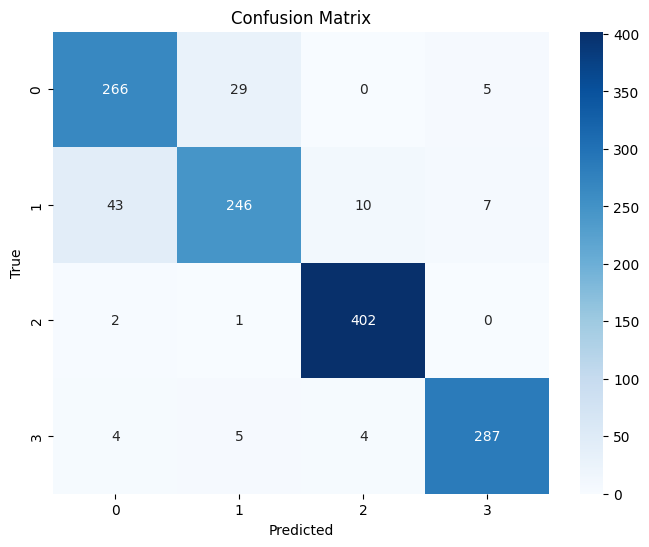

In [259]:
plot_confusion_matrix(y_test,dst_predicts,labels=[0,1,2,3])

In [ ]:
dst_predicts

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!keras --version


'keras' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!tensorflow --version

'tensorflow' is not recognized as an internal or external command,
operable program or batch file.


# SINGLE IMAGE PROCESSING

In [92]:
image_single = "Dataset\Testing\glioma\Te-gl_0022.jpg"



In [104]:
import base64

def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode the image bytes as base64 string
        base64_string = base64.b64encode(img_bytes).decode('utf-8')
    return base64_string

# Example usage:
base64_string = image_to_base64(image_single)
print(base64_string)


/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAIAAgADASIAAhEBAxEB/8QAHQABAAIDAQEBAQAAAAAAAAAAAAIEAwUGBwgJAf/EAEYQAAEDAgQEAwUFBAgFBAMAAAIAAwQFEgYTIjIHFCNCM1JiCBVDYXIBFiRTghE0Y3MJFyElMZKisiY1RHHCGEFRVFWB4v/EABQBAQAAAAAAAAAAAAAAAAAAAAD/xAAUEQEAAAAAAAAAAAAAAAAAAAAA/9oADAMBAAIRAxEAPwD8qkREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBEUrPmgiilZ80s+aCKKVnzSz5oIopWfNLPmgiilZ80QRRSU0GJFJTQYkWVQQRRSU0GJf237Vks+aIMdv2pb9qyIgx2/alv2rIiDHb9qW/asiIMdv2pb9qyJZ80GO37Ut+1ZEQYl/bftWREGJFlRBiRZUQYkUkQRRZVCz5oIopJZ80EUUk7EEUREBERAREQEREBERAREQEREBERAREQEREBZViWVAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBRLapJ2IMSIiAiIgIiICIiAiIgIiICIiAiIgIiICIiD+ju+xZFFoLy/YpWfNARTBlw/hmpZL/5diDEinZ80Blw0EEWXJ/MS0EGJFl6PrQAbM/IgxIrBsgAb1Bmz4mtBiRWzBsx0ApR

In [115]:
def display_image(image_array):
    """
    Display an image from a NumPy array using Matplotlib.

    Parameters:
        image_array (numpy.ndarray): The image array to be displayed.
    """
    # Reshape the array to remove the singleton dimension if present
    image_array = np.squeeze(image_array)

    # Display the image using Matplotlib
    plt.imshow(image_array, cmap='gray')  # Assuming the image is grayscale
    plt.axis('off')  # Turn off axis
    plt.show()

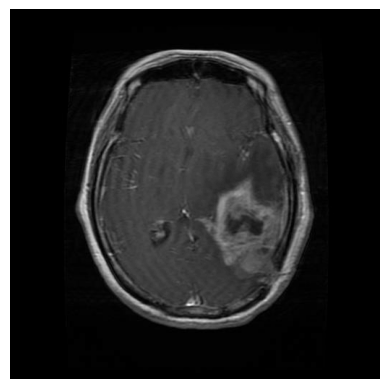

TensorShape([512, 512, 1])

In [137]:
decoded = tf.image.decode_image(base64.b64decode(base64_string),channels=1,)
display_image(decoded)
decoded.shape

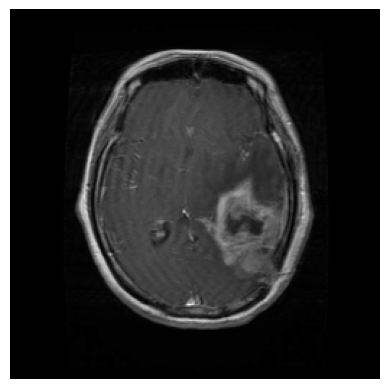

In [117]:
reshaped = tf.image.resize(decoded,(256,256))
display_image(reshaped)

In [165]:
reshaped

<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

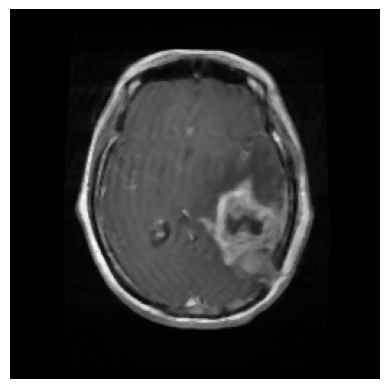

TensorShape([256, 256, 1])

In [130]:
filtered = median_filter2d(reshaped)
display_image(filtered)
filtered.shape

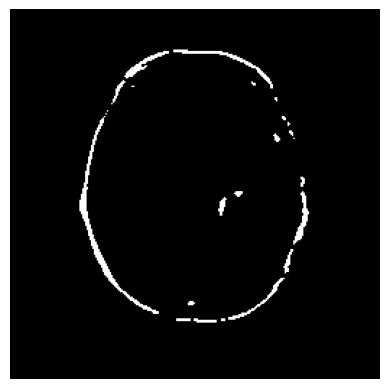

TensorShape([256, 256, 1])

In [134]:
segmented = segment_image(filtered,0)[0]
display_image(segmented)
segmented.shape

tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(256, 256, 1), dtype=float32)
0


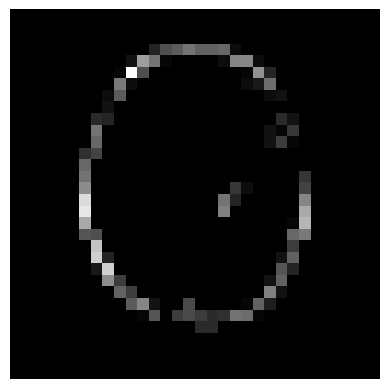

TensorShape([32, 32, 1])

In [142]:
dwt_extract = dwt_applier(segmented,0)[0]
display_image(dwt_extract)
dwt_extract.shape

In [147]:
img_np = dwt_extract.numpy()
img_np.shape

(32, 32, 1)

In [221]:
# ANN
image_ann = img_np.reshape([1,32,32,1])
ann_ =model.predict(image_ann)
ann_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[9.7533280e-01, 2.4537429e-02, 1.0358072e-04, 2.6248619e-05]],
      dtype=float32)

In [222]:

image_knn = img_np.flatten().reshape([1,1024])
knn_ = knn.predict_proba(image_knn)
knn_

array([[0., 0., 1., 0.]])

In [235]:
svm_ =svm.predict_proba(image_knn/255.0)
svm_.shape

(1, 4)

In [224]:
apply_dst(knn_preds=knn_,svm_preds=svm_,ann_preds=ann_)

{{2}:1.0; {0}:0.0; {1}:0.0; {3}:0.0; set():0.0}
{{2}:1.0; {0}:0.0; {1}:0.0; {3}:0.0}
{{2}:1.0; {0}:0.0; {1}:0.0; {3}:0.0}
{{2}:1.0; {0}:0.0; {1}:0.0; {3}:0.0}
Predicted class: 2


[2]

In [262]:
results = []
for n in range(10,50
               ): 
    image_single = f"Dataset\Testing\glioma\Te-gl_00{n}.jpg"
    base64_string = image_to_base64(image_single)
    decoded = tf.image.decode_image(base64.b64decode(base64_string),channels=1)
    
    reshaped = tf.image.resize(decoded,(256,256))
    # display_image(reshaped)
    filtered = median_filter2d(reshaped)
    # display_image(filtered)
    segmented = segment_image(filtered,0)[0]
    dwt_extract = dwt_applier(segmented,0)[0]
    # display_image(segmented)
    img_np = dwt_extract.numpy()
    image_ann = img_np.reshape([1,32,32,1])
    ann_ =model.predict(image_ann)

    image_knn = img_np.flatten().reshape([1,1024])
    knn_ = knn.predict_proba(image_knn/255.0)
    svm_ =svm.predict_proba(image_knn/255.0)

    
    # result = apply_dst(knn_preds=knn_,svm_preds=svm_,ann_preds=ann_)
    belief_function_knn = probabilities_to_belief_function(knn_[0])
    belief_function_svm = probabilities_to_belief_function(svm_[0])
    belief_function_ann = probabilities_to_belief_function(ann_[0])
    print(belief_function_ann)
    print(belief_function_knn)
    print(belief_function_svm)
    # Combine belief functions from all classifiers
    combined_belief = combine_belief_functions(belief_function_ann,  belief_function_knn,belief_function_svm)

    # Make decisions based on the combined belief function
    # Find the class with the highest mass value
    max_mass = -1
    max_class = None
    for subset, mass in combined_belief.items():
        if mass > max_mass:
            max_mass = mass
            max_class = next(iter(subset))
    # Append the predicted class
    result = max_class
    results.append((result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
{{0}:0.9961888; {1}:0.0031948674; {3}:0.00061629334; {2}:9.1109154e-14; set():0.0}
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0; set():0.0}
{{0}:0.7015721606345914; {1}:0.25018026833230983; {3}:0.03363956385739154; {2}:0.014608007175707307; set():0.0}
_________________________________
{{0}:0.9961888194084167; {1}:0.0031948674004524946; {3}:0.0006162933423183858; {2}:9.110915418376192e-14; set():0.0}
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0}
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
{{0}:0.9979747; {1}:0.002019857; {3}:5.5108844e-06; {2}:3.3270414e-08; set():0.0}
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0; set():0.0}
{{0}:0.5852125074487688; {1}:0.3951798969167969; {3}:0.01065564107716861; {2}:0.008951954557265641; set():0.0}
_________________________________
{{0}:0.997974693775177; {1}:0.002019857056438923; {3}:5.510884420800721e-06; {2}:3.3270413979380464e-08; set():0.0}
{{0}:1.0; {1}:0.0; {2}:0.0; {3}:0.0}
{{0}:1.0; {1}:0.0; {2}:0.0

In [263]:
results

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0]